                  count        mean          std            min  25%      50%  \
classification                                                                  
Extreme Fear     2326.0    1.891632    76.727713   -1430.889856  0.0  0.00000   
Extreme Greed    5621.0  205.816345  1861.557119  -18360.670070  0.0  0.96048   
Fear            13869.0  128.287950  1342.348497  -19841.240140  0.0  0.00000   
Greed           11292.0   53.988003  1399.468182 -117990.104100  0.0  0.00000   
Neutral          2756.0   27.088803   142.945889   -1032.981540  0.0  0.00000   

                      75%           max  
classification                           
Extreme Fear     0.298102   2020.000000  
Extreme Greed   30.153710  44223.451870  
Fear             8.201820  71535.716740  
Greed           13.441364  34903.817100  
Neutral          9.267691   2979.554311  


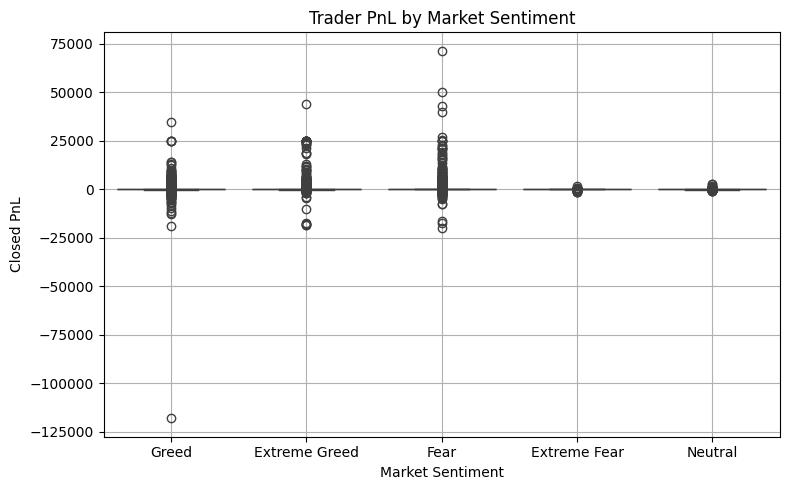

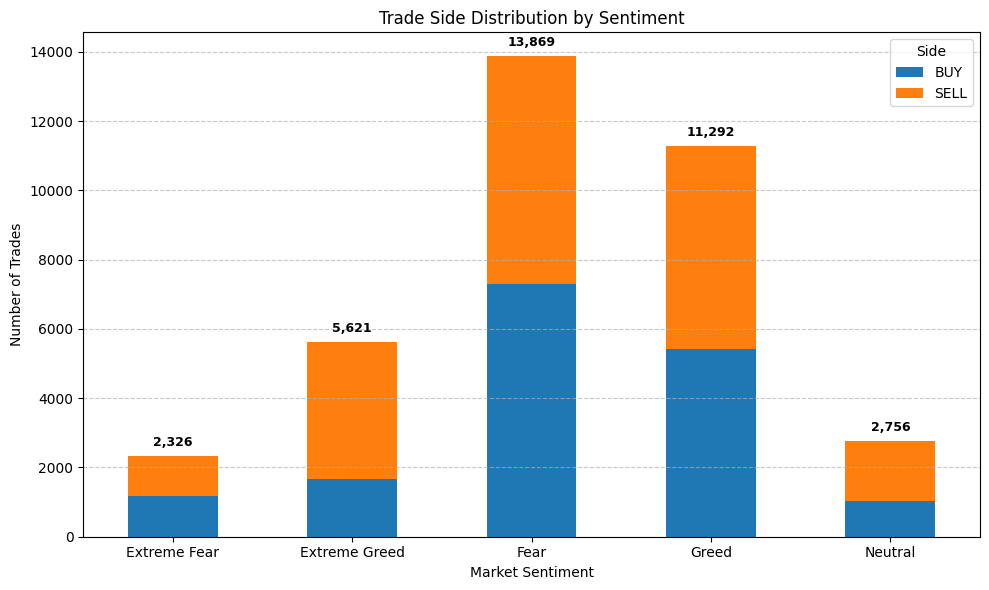

side             BUY  SELL  Total Trades
classification                          
Fear            7307  6562         13869
Greed           5407  5885         11292
Extreme Greed   1661  3960          5621
Neutral         1020  1736          2756
Extreme Fear    1168  1158          2326
classification
Extreme Fear     4118.761840
Extreme Greed    3242.085086
Fear             5744.782685
Greed            5051.878829
Neutral          4332.202906
Name: size_usd, dtype: float64
classification
Extreme Fear     0.686479
Extreme Greed    0.835794
Fear             1.131521
Greed            1.092947
Neutral          0.922389
Name: fee, dtype: float64


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Load CSV files
trades = pd.read_csv('../data/trader_data.csv')
sentiment = pd.read_csv('../data/sentiment_data.csv')

# Clean column names
trades.columns = trades.columns.str.strip().str.lower().str.replace(' ', '_')
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(' ', '_')

# Convert timestamp from 'timestamp_ist' column
trades['timestamp'] = pd.to_datetime(trades['timestamp_ist'], errors='coerce')
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')

# Drop rows with missing timestamps
trades = trades.dropna(subset=['timestamp'])

# Create date-only columns for merging
trades['trade_date'] = trades['timestamp'].dt.strftime('%Y-%m-%d')
sentiment['sentiment_date'] = sentiment['date'].dt.strftime('%Y-%m-%d')
# Merge on date
merged = trades.merge(sentiment, left_on='trade_date', right_on='sentiment_date', how='left')

# Preview key columns
merged[['account', 'coin', 'execution_price', 'closed_pnl', 'classification']].head()
# Summary of PnL by sentiment
pnl_stats = merged.groupby('classification')['closed_pnl'].describe()
print(pnl_stats)
# Create images folder if needed
os.makedirs('../images', exist_ok=True)

plt.figure(figsize=(8, 5))
sns.boxplot(x='classification', y='closed_pnl', data=merged)
plt.title('Trader PnL by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/pnl_by_sentiment.png')
plt.show()
# Annotated Trade Side Distribution
trade_counts = merged.groupby(['classification', 'side']).size().unstack()
ax = trade_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])

for i, sentiment in enumerate(trade_counts.index):
    buy = trade_counts.loc[sentiment, 'BUY'] if 'BUY' in trade_counts.columns else 0
    sell = trade_counts.loc[sentiment, 'SELL'] if 'SELL' in trade_counts.columns else 0
    total = buy + sell
    ax.text(i, total + 200, f'{total:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('Trade Side Distribution by Sentiment')
plt.ylabel('Number of Trades')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=0)
plt.legend(title='Side')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('../images/trade_side_by_sentiment_annotated.png')
plt.show()
# Summary table of trade sides by sentiment
summary_table = merged.groupby(['classification', 'side']).size().unstack().fillna(0).astype(int)
summary_table['Total Trades'] = summary_table.sum(axis=1)
summary_table = summary_table.sort_values('Total Trades', ascending=False)
print(summary_table)
# Average trade size by sentiment
print(merged.groupby('classification')['size_usd'].mean())

# Average fee by sentiment
print(merged.groupby('classification')['fee'].mean())

